In [1]:
## Generating Customers, Terminals and Transactions Data
We now generate a dataset of legitimate and fraudulent transactions.

A __transaction__ consists of any amount paid to a merchant by a customer at a certain time.

The six main features that summarise a transaction are:
1. __The transaction ID__: A unique identifier for the transaction
2. __The date and time__: Date and time at which the transaction occurs
3. __The customer ID__: The identifier for the customer. Each customer has a unique identifier
4. __The terminal ID__: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier
5. __The transaction amount__: The amount of the transaction.
6. __The fraud label__: A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction.

### Entities
`Customers`: geo, spending frequency, spending amount, available_terminals (we assume customers only make transactions on terminals that are within a radius of _RADIUS_ of their geo)

`Terminals`: geo

`Transactions`: generated for each customers according to their properties and labeled as legitimate (0) or fraudulent (1)

### Fraud Scenarios
- __Scenario 1__: any transaction whose amount is more than 220. This will provide an obvious fraud pattern that should be detected always.
- __Scenario 2__: every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent.
- __Scenario 3__: every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent.


#### Notes

The simulated datasets will highlight most of the issues that practitioners of fraud detection face using real-world data. In particular, they will include __class imbalance__ (less than 1% of fraudulent transactions), a mix of __numerical and categorical features__, non-trivial __relationships between features__, and __time-dependent__ fraud scenarios.

Code and Inspiration taken from: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html

SyntaxError: invalid syntax (<ipython-input-1-c61ced9639d5>, line 2)

In [2]:
!pip install pandas --upgrade

     |████████████████████████████████| 11.6 MB 9.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
You should consider upgrading via the '/Users/gargj/Projects/DSI/Exploration/venv/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
import datetime

In [4]:
NUMBER_OF_CUSTOMERS = 5000
NUMBER_OF_TERMINALS = 10000
RANDOM_STATE_CUSTOMERS = random.randint(0,1000000)
RANDOM_STATE_TERMINALS = random.randint(0,1000000)
RADIUS = 5
NUMBER_OF_DAYS = 183
START_DATE = "2018-04-01"
DIR_OUTPUT = "./data/generated/"

In [5]:
## Functions

In [6]:
def generate_customers(n, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [7]:
def generate_terminals(n, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [8]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

In [9]:
def plot_customer_terminals(customer_x, customer_y, terminals_df, radius):
    terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

    # Plot locations of terminals
    ax.scatter(terminals_df.x_terminal_id.values, 
               terminals_df.y_terminal_id.values, 
               s = 0.5,
               color='blue', label = 'Locations of terminals')

    # Plot location of the last customer
    customer_id=4
    ax.scatter(customer_x, 
               customer_y, 
               color='red',label="Location of last customer")

    ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))

    # Plot the region within a radius of 50 of the last customr
    circ = plt.Circle((customer_x,
                       customer_y), radius=radius, color='g', alpha=0.2)
    ax.add_patch(circ)

    fontsize=15

    ax.set_title("Green circle: \n Terminals within a radius of 50 \n of the last customer")
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])

    ax.set_xlabel('x_terminal_id', fontsize=fontsize)
    ax.set_ylabel('y_terminal_id', fontsize=fontsize)
    plt.show()

In [10]:
def generate_transactions(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(customer_profile.CUSTOMER_ID)
    np.random.seed(customer_profile.CUSTOMER_ID)
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions

In [11]:
def plot_transactions_over_time(transactions_df):
    distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

    amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(10000, replace=True).values
    time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(10000, replace=True).values

    sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
    ax[0].set_title('Distribution of transaction amounts', fontsize=14)
    ax[0].set_xlim([min(amount_val), max(amount_val)])
    ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

    # We divide the time variables by 86400 to transform seconds to days in the plot
    sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
    ax[1].set_title('Distribution of transaction over time', fontsize=14)
    ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
    ax[1].set_xticks(range(10))
    ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")
    plt.show()

In [12]:
def add_frauds(customers_df, terminals_df, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminals_df.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customers_df.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    print(f"Fraudulent transactions: {transactions_df.TX_FRAUD.sum()}/{len(transactions_df)} : {round(transactions_df.TX_FRAUD.mean(),3)}%")
    
    return transactions_df

In [13]:
def generate_dataset(n_customers, n_terminals, nb_days, start_date, radius, random_state_customers, random_state_terminals):
    print("Generating customers")
    customer_profiles_table = generate_customers(n_customers, random_state = random_state_customers)
    print(f"Generated {len(customer_profiles_table)} customers\n")
    
    print("Generating terminals")
    terminal_profiles_table = generate_terminals(n_terminals, random_state = random_state_terminals)
    print(f"Generated {len(terminal_profiles_table)} terminals\n")
    
    
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=radius), axis=1)

    print("Associating terminals to customers")
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Associated terminals to customers\n")
    
    print("Generating transactions\n")
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print(f"Generated {len(transactions_df)} transactions\n")
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    print("Adding frauds")
    transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)
    print("Added frauds")
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)
    

In [14]:
def plot_transactions_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    n_days=len(nb_tx_per_day)
    tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
    tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
    tx_stats=tx_stats.reset_index()
    
    sns.set(style='darkgrid')
    sns.set(font_scale=1.4)

    fraud_and_transactions_stats_fig = plt.gcf()

    fraud_and_transactions_stats_fig.set_size_inches(15, 8)

    sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

    sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of frauded cards per day', fontsize=20)
    sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

    sns_plot.set_ylim([0,300])

    labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

    sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)
    
    plt.show()

In [15]:
def save_data(customers_df, terminals_df, transactions_df):
    base_dir_output = DIR_OUTPUT + time.strftime("%Y%m%d-%H%M%S") + "/"

    # Saving customers
    print("Saving customers")
    filename_output = "customers.pkl"
    dir_output = base_dir_output + "customers/"
    if not os.path.exists(dir_output):
        os.makedirs(dir_output)
    customers_df.to_pickle(dir_output+filename_output)
    print("Saved customers")
    
    # Saving terminals
    print("Saving terminals")
    filename_output = "terminals.pkl"
    dir_output = base_dir_output + "terminals/"
    if not os.path.exists(dir_output):
        os.makedirs(dir_output)
    terminals_df.to_pickle(dir_output+filename_output)
    print("Saved terminals")
    
    # Saving transactions
    print("Saving transactions")
    start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
    dir_output = base_dir_output + "transactions/"
    if not os.path.exists(dir_output):
        os.makedirs(dir_output)

    for day in range(transactions_df.TX_TIME_DAYS.max()+1):

        transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')

        date = start_date + datetime.timedelta(days=day)
        filename_output = date.strftime("%Y-%m-%d")+'.pkl'

        transactions_day.to_pickle(dir_output+filename_output)
    print("Saved transactions")

In [16]:
#### Generating Data

In [17]:
(customers_df, terminals_df, transactions_df )=\
    generate_dataset(NUMBER_OF_CUSTOMERS, 
                     NUMBER_OF_TERMINALS, 
                     NUMBER_OF_DAYS, 
                     START_DATE,
                     RADIUS,
                     RANDOM_STATE_CUSTOMERS,
                     RANDOM_STATE_TERMINALS)

Generating customers
Generated 5000 customers

Generating terminals
Generated 10000 terminals

Associating terminals to customers
Associated terminals to customers

Generating transactions

<ipython-input-10-18fc113ec32a>:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(customer_profile.CUSTOMER_ID)
Generated 1789516 transactions

Adding frauds
Number of frauds from scenario 1: 967
Number of frauds from scenario 2: 9052
Number of frauds from scenario 3: 4516
Fraudulent transactions: 14535/1789516 : 0.008%
Added frauds


In [18]:
save_data(customers_df, terminals_df, transactions_df)

Saving customers
Saved customers
Saving terminals
Saved terminals
Saving transactions
Saved transactions


/Users/gargj/Projects/DSI/Exploration/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


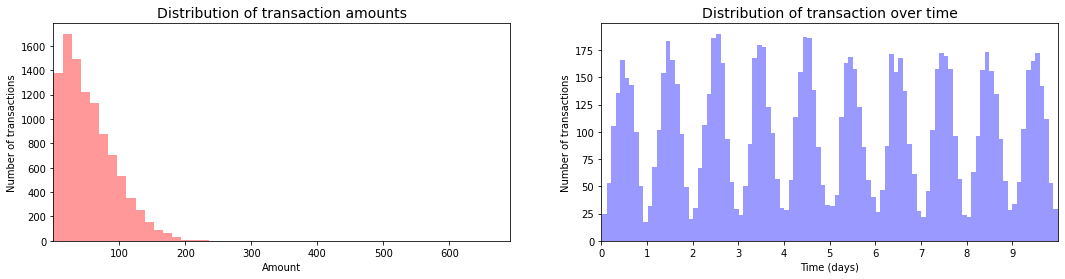

In [19]:
plot_transactions_over_time(transactions_df)

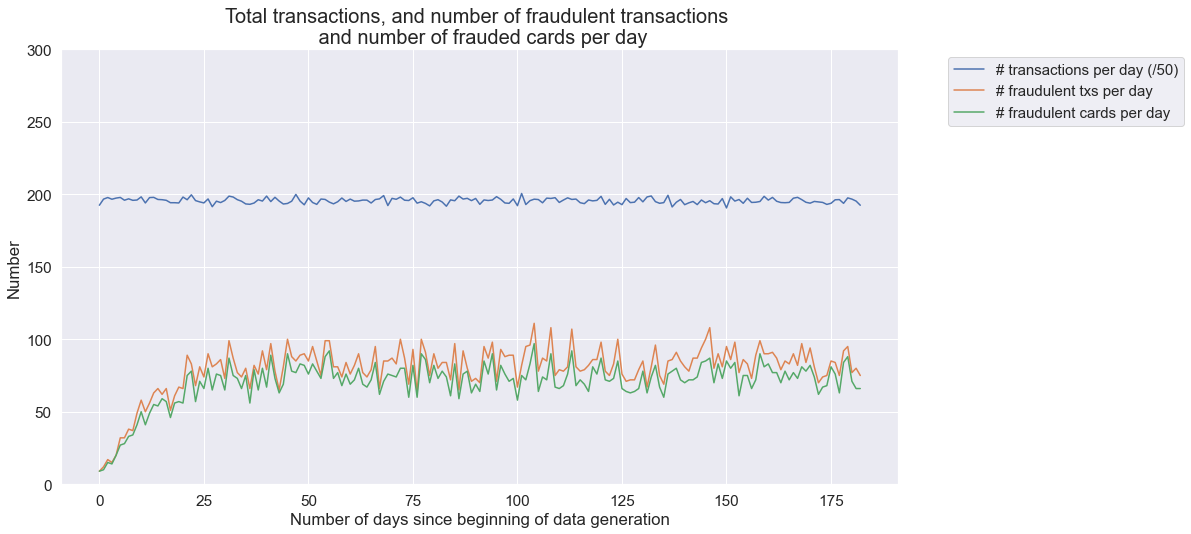

In [20]:
plot_transactions_stats(transactions_df)